In [10]:
import rdflib
import numpy as np
import torch
from pykeen.triples import TriplesFactory
from pykeen.models.inductive import InductiveNodePieceGNN
from pykeen.losses import NSSALoss
from torch.optim import Adam
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation import SampledRankBasedEvaluator, RankBasedEvaluator
from pykeen.stoppers import EarlyStopper
from pykeen.predict import predict_target, predict_all, predict_triples
from pykeen.checkpoints import save_model

import torch.nn.functional as F
from modular_methods.similarity_utils import compute_cosine_similarity, match_entities
from modular_methods.graphToText_utils import get_literals_for_entities
from modular_methods.dedup_pipeline import deduplicate_graphs, save_matches
from modular_methods.output_utils import build_final_result

### ---- 1. Load RDF graphs ----

train_graph = rdflib.Graph()
test_combined = rdflib.Graph()

train_graph.parse("data/train_combined_NodePiece.ttl")
test_combined.parse("data/test_combined_NodePiece.ttl")

def graph_to_triples(g):
    return [
        (str(s), str(p), str(o))
        for s, p, o in g
        if isinstance(s, rdflib.URIRef) and isinstance(o, rdflib.URIRef)
    ]

train_triples = np.array(graph_to_triples(train_graph))
test_triples = np.array(graph_to_triples(test_combined))


In [2]:
# Extract unique relations from train and test triples
train_relations = set(train_triples[:, 1])
test_relations = set(test_triples[:, 1])

# Find common and unique relations
common_relations = train_relations & test_relations
train_only_relations = train_relations - test_relations
test_only_relations = test_relations - train_relations

print(f"Number of relations in train: {len(train_relations)}")
print(f"Number of relations in test: {len(test_relations)}")
print(f"Number of common relations: {len(common_relations)}")
print(f"Relations only in train: {train_only_relations}")
print(f"Relations only in test: {test_only_relations}")

Number of relations in train: 7
Number of relations in test: 6
Number of common relations: 6
Relations only in train: {'http://www.w3.org/2002/07/owl#sameAs'}
Relations only in test: set()


In [3]:
### ---- 3. Build TriplesFactory objects ----

tf_train = TriplesFactory.from_labeled_triples(train_triples, create_inverse_triples=True)
tf_test = TriplesFactory.from_labeled_triples(
    test_triples,
    relation_to_id=tf_train.relation_to_id,
    create_inverse_triples=True
)

inductive_inference, inductive_validation, inductive_testing = tf_test.split(ratios=(0.8, 0.1), random_state=69)

In [4]:
inductive_validation

TriplesFactory(num_entities=1563, num_relations=7, create_inverse_triples=False, num_triples=388)

In [5]:
### ---- 4. Train InductiveNodePieceGNN ----

model = InductiveNodePieceGNN(
    triples_factory=tf_train,
    inference_factory=inductive_inference,
    num_tokens=12,
    aggregation="mlp",
    embedding_dim=128,
    loss=NSSALoss(margin=15),
    random_seed=42,
    gnn_encoder=None,  # Use default GNN encoder
).to("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=0.0005)

training_loop = SLCWATrainingLoop(
    triples_factory=tf_train,
    model=model,
    optimizer=optimizer,
    mode="training"
)
valid_evaluator = SampledRankBasedEvaluator(
    mode ="validation",
    evaluation_factory=inductive_validation,
    additional_filter_triples=[inductive_inference.mapped_triples],
)

test_evaluator = SampledRankBasedEvaluator(
    mode="testing",
    evaluation_factory=inductive_testing,
    additional_filter_triples=[
        inductive_inference.mapped_triples,
    ],
)

early_stopper = EarlyStopper(
    model=model,
    training_triples_factory=tf_train,
    evaluation_triples_factory=inductive_validation,
    frequency=1,
    patience=2,  # Adjust patience as needed
    result_tracker=None,
    evaluation_batch_size=128,
    evaluator=valid_evaluator,
)

print("Training NodePiece...")
training_loop.train(
    triples_factory=tf_train,
    num_epochs=40)


# Save the trained model to a file
save_model(model, "nodepiece_gnn_trained.pt")
print("Model saved to nodepiece_gnn_trained.pt")

No symbolic computation of output shape.                       
No symbolic computation of output shape.              


Training NodePiece...


Training epochs on cpu: 100%|██████████| 40/40 [12:49<00:00, 19.23s/epoch, loss=0.225, prev_loss=0.219]

Model saved to nodepiece_gnn_trained.pt


<http://www.w3.org/2002/07/owl:sameAs

In [13]:
# Predict all tail candidates for all heads
all_predictions = predict_all(
    model=model,
    k=5,  # adjust as needed
    mode="testing",
    target="tail"
)

# Convert to dataframe
all_df = all_predictions.process(factory=inductive_inference)

predict is an expensive operation, involving 98,805,343 score evaluations.


In [16]:
from pykeen.predict import predict_triples
import pandas as pd
import itertools

# 1. Get all entity labels (not classes) from inductive_inference
def get_entity_type(label):
    # Adjust this function to your URI pattern
    parts = label.split('example.org/')
    if len(parts) > 1:
        return parts[1].split('/')[0]
    return None

entity_labels = [lbl for lbl in inductive_inference.entity_to_id.keys() if 'example.org/' in lbl]
entity_types = {}
for lbl in entity_labels:
    etype = get_entity_type(lbl)
    if etype:
        entity_types.setdefault(etype, []).append(lbl)

# 2. Generate all possible (head, tail) pairs within each entity type (excluding self-pairs)
candidate_triples = []
sameas_uri = 'http://www.w3.org/2002/07/owl#sameAs'
for etype, entities in entity_types.items():
    for h, t in itertools.permutations(entities, 2):
        candidate_triples.append((h, sameas_uri, t))

print(f"Total candidate triples: {len(candidate_triples)}")

# 3. Predict scores for these triples
predicted_sameas = predict_triples(
    mode="testing",
    model=model,
    triples=candidate_triples,
    triples_factory=inductive_inference,
    batch_size=128
)

# 4. Convert to DataFrame and sort by score
df = predicted_sameas.process(factory=inductive_inference).df
df_sorted = df.sort_values(by="score", ascending=False)
print(df_sorted.head())

# Optionally: Save or further filter as needed
df_sorted.to_csv("predicted_sameas_entities_only.csv", index=False)

Total candidate triples: 805590


Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


        head_id                                         head_label  \
130617      513  http://example.org/HealthcareOrganization/06d2...   
131402      541  http://example.org/HealthcareOrganization/dcda...   
130608      513  http://example.org/HealthcareOrganization/06d2...   
131141      532  http://example.org/HealthcareOrganization/953e...   
131342      538  http://example.org/HealthcareOrganization/c740...   

        relation_id                        relation_label  tail_id  \
130617            1  http://www.w3.org/2002/07/owl#sameAs      541   
131402            1  http://www.w3.org/2002/07/owl#sameAs      513   
130608            1  http://www.w3.org/2002/07/owl#sameAs      532   
131141            1  http://www.w3.org/2002/07/owl#sameAs      513   
131342            1  http://www.w3.org/2002/07/owl#sameAs      541   

                                               tail_label     score  
130617  http://example.org/HealthcareOrganization/dcda... -6.282637  
131402  http://exa

In [ ]:
from pykeen.predict import predict_triples
import pandas as pd
import itertools
import numpy as np

# --- SETTINGS ---
sameas_uri = 'http://www.w3.org/2002/07/owl#sameAs'
top_k = 5  # change this to keep more/less matches per entity

# --- FUNCTIONS ---
def get_entity_type(label):
    """Extract entity type from URI pattern."""
    parts = label.split('example.org/')
    if len(parts) > 1:
        return parts[1].split('/')[0]
    return None

# 1. Get all entity labels (not classes) from inductive_inference
entity_labels = [lbl for lbl in inductive_inference.entity_to_id.keys() if 'example.org/' in lbl]
entity_types = {}
for lbl in entity_labels:
    etype = get_entity_type(lbl)
    if etype:
        entity_types.setdefault(etype, []).append(lbl)

# 2. Generate all possible (head, tail) pairs within each entity type (unique combos)
candidate_triples = []
for etype, entities in entity_types.items():
    for h, t in itertools.combinations(entities, 2):
        candidate_triples.append((h, sameas_uri, t))

print(f"Total candidate triples: {len(candidate_triples)}")

# 3. Predict scores for these triples
predicted_sameas = predict_triples(
    mode="testing",
    model=model,
    triples=candidate_triples,
    triples_factory=inductive_inference,
    batch_size=128
)


Total candidate triples: 402795


Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
d:\Program Files\Uni\Master Scriptie\Code Snippets\entity-deduplication-hack-main\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: 'head'

In [20]:
df

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,score_normalized
0,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,1,http://example.org/Address/02299f58-9071-414d-...,-51.244480,5.556548e-23
1,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,2,http://example.org/Address/022c88c0-b563-446c-...,-37.386425,5.798049e-17
2,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,3,http://example.org/Address/0463e993-501b-4397-...,-51.244480,5.556548e-23
3,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,4,http://example.org/Address/054efa50-4962-473b-...,-37.634792,4.522904e-17
4,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,5,http://example.org/Address/055c64dd-e478-40a6-...,-51.244480,5.556548e-23
...,...,...,...,...,...,...,...,...
402790,1554,http://example.org/ServiceDepartment/fd984477-...,1,http://www.w3.org/2002/07/owl#sameAs,1556,http://example.org/ServiceDepartment/fdc8d008-...,-23.151579,8.818547e-11
402791,1554,http://example.org/ServiceDepartment/fd984477-...,1,http://www.w3.org/2002/07/owl#sameAs,1557,http://example.org/ServiceDepartment/fee0220a-...,-22.100304,2.523249e-10
402792,1555,http://example.org/ServiceDepartment/fdc68520-...,1,http://www.w3.org/2002/07/owl#sameAs,1556,http://example.org/ServiceDepartment/fdc8d008-...,-23.729727,4.946643e-11
402793,1555,http://example.org/ServiceDepartment/fdc68520-...,1,http://www.w3.org/2002/07/owl#sameAs,1557,http://example.org/ServiceDepartment/fee0220a-...,-21.676064,3.856606e-10


In [25]:
# 4. Convert to DataFrame
df = predicted_sameas.process(factory=inductive_inference).df

# 5. Normalize scores: z-score + sigmoid
scores = df['score'].values
mean, std = scores.mean(), scores.std()
df['score_normalized'] = 1 / (1 + np.exp(-(scores - mean) / (std + 1e-8)))

# 6. Sort and filter top-k matches per head entity
df_sorted = df.sort_values(by="score_normalized", ascending=False)
df_topk = df_sorted.groupby("head_label").head(top_k)

# 7. Save to CSV
df_topk.to_csv("predicted_sameas_topk_sigmoid_scaled.csv", index=False)

print(f"Filtered and normalized results saved to predicted_sameas_topk_sigmoid_scaled.csv "
      f"(top-{top_k} matches per head).")
print(df_topk.head())

Filtered and normalized results saved to predicted_sameas_topk_sigmoid_scaled.csv (top-5 matches per head).
       head_id                                         head_label  \
65336      513  http://example.org/HealthcareOrganization/06d2...   
65327      513  http://example.org/HealthcareOrganization/06d2...   
65711      538  http://example.org/HealthcareOrganization/c740...   
65675      532  http://example.org/HealthcareOrganization/953e...   
65503      520  http://example.org/HealthcareOrganization/4a86...   

       relation_id                        relation_label  tail_id  \
65336            1  http://www.w3.org/2002/07/owl#sameAs      541   
65327            1  http://www.w3.org/2002/07/owl#sameAs      532   
65711            1  http://www.w3.org/2002/07/owl#sameAs      541   
65675            1  http://www.w3.org/2002/07/owl#sameAs      538   
65503            1  http://www.w3.org/2002/07/owl#sameAs      540   

                                              tail_label     s

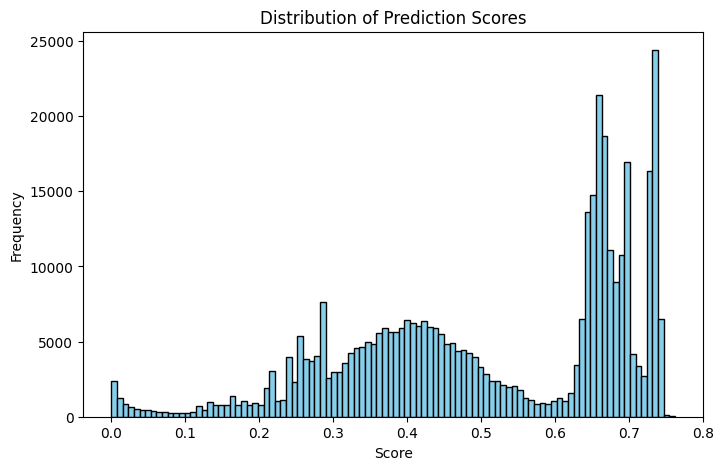

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['score_normalized'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Scores')
plt.show()

In [10]:
# Convert from IDs to readable labels
triple_predictions = predicted_sameas.process(factory=inductive_inference)

# Get Pandas DataFrame
df = triple_predictions.df

# Inspect top predictions
df_sorted = df.sort_values(by="score", ascending=False)
print(df_sorted.head(10))


         head_id                                         head_label  \
2436866     1560             https://schema.org/MedicalOrganization   
229611       146  http://example.org/Address/99755cb9-7c76-4592-...   
35923         22  http://example.org/Address/19d5f970-98b3-4c6e-...   
2436742     1560             https://schema.org/MedicalOrganization   
154635        98  http://example.org/Address/6756264d-c864-4f78-...   
2436818     1560             https://schema.org/MedicalOrganization   
181189       115  http://example.org/Address/73c52606-d244-4503-...   
2436835     1560             https://schema.org/MedicalOrganization   
2436750     1560             https://schema.org/MedicalOrganization   
48419         30  http://example.org/Address/255fd937-7dd6-4794-...   

         relation_id                        relation_label  tail_id  \
2436866            1  http://www.w3.org/2002/07/owl#sameAs      146   
229611             1  http://www.w3.org/2002/07/owl#sameAs     1560   
35923

In [18]:
def get_base(label):
    # Extract base type after 'example.org/' and before next '/'
    parts = label.split('example.org/')
    if len(parts) > 1:
        base = parts[1].split('/')[0]
        return base
    return None

df_sorted['head_base'] = df_sorted['head_label'].apply(get_base)
df_sorted['tail_base'] = df_sorted['tail_label'].apply(get_base)
df_filtered = df_sorted[df_sorted['head_base'] == df_sorted['tail_base']].drop(columns=['head_base', 'tail_base'])

In [ ]:
# # Filter out rows where score is greater than -50
# filtered_scores = df_filtered[df_filtered['score'] > -30]
# filtered_scores.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
23,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,24,http://example.org/Address/1ae3237f-aa88-4965-...,-29.091862
24,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,25,http://example.org/Address/1ba43eaf-84f4-4346-...,-29.065649
25,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,26,http://example.org/Address/1c7bc6c8-d62f-4e8c-...,-26.688372
27,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,28,http://example.org/Address/21ab9e3d-fdf4-4f09-...,-27.908621
30,0,http://example.org/Address/014ef9de-b7ac-42bf-...,1,http://www.w3.org/2002/07/owl#sameAs,31,http://example.org/Address/25b09e48-1ca1-4fa7-...,-29.524300


In [21]:
df_filtered.to_csv("predicted_sameas_sorted_new.csv", index=False)
df_filtered.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
1675006,1072,http://example.org/Person/b1715fad-1c46-46c3-a...,1,http://www.w3.org/2002/07/owl#sameAs,542,http://example.org/Person/0116d36e-bba3-48dc-b...,-6.598727
1753106,1122,http://example.org/Person/c2b3b21b-2fa5-4e0c-9...,1,http://www.w3.org/2002/07/owl#sameAs,542,http://example.org/Person/0116d36e-bba3-48dc-b...,-6.598727
1240770,794,http://example.org/Person/59636b2f-de8b-4854-b...,1,http://www.w3.org/2002/07/owl#sameAs,542,http://example.org/Person/0116d36e-bba3-48dc-b...,-6.598727
895568,573,http://example.org/Person/09d962da-bdad-4303-a...,1,http://www.w3.org/2002/07/owl#sameAs,542,http://example.org/Person/0116d36e-bba3-48dc-b...,-6.598727
1093942,700,http://example.org/Person/335e9218-950e-4154-8...,1,http://www.w3.org/2002/07/owl#sameAs,542,http://example.org/Person/0116d36e-bba3-48dc-b...,-6.598727


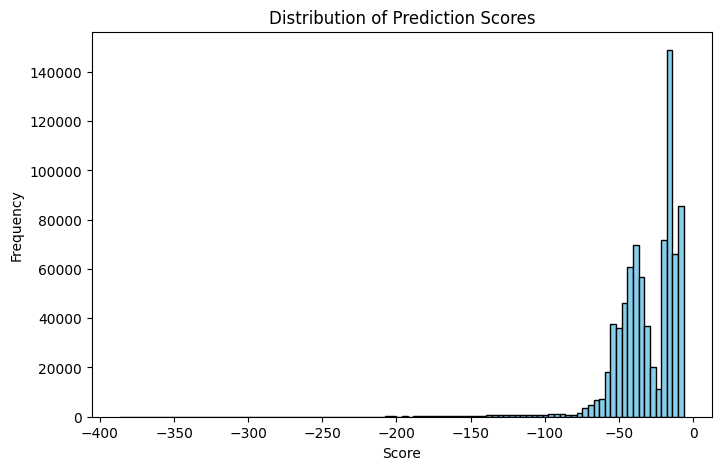

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_sorted['score'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Scores')
plt.show()

In [14]:
result = test_evaluator.evaluate(
    model=model,
    mapped_triples=inductive_testing.mapped_triples,
    additional_filter_triples=[
    inductive_inference.mapped_triples,
    inductive_validation.mapped_triples
    ],
    batch_size=128 
    )




Evaluating on cpu:   0%|          | 0.00/388 [00:00<?, ?triple/s]Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 388/388 [00:00<00:00, 1.58ktriple/s]
